In [16]:
import json

import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt

from sympy.interactive import printing
printing.init_printing(use_latex=True)
from sympy import Eq, solve_linear_system, Matrix
import sympy as sp

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

json_file_path = "ad-hoc/transaction-data-adhoc-analysis.json"
    
df = pd.read_json (r'transaction-data-adhoc-analysis.json')

In [11]:
# convert transaction date from string to datetime value
df['transaction_date']= pd.to_datetime(df['transaction_date'])
# extract transaction month and convert to month name
df['Transaction Month'] = pd.to_datetime(df['transaction_date']).dt.month
df['Transaction Month'] = pd.to_datetime(df['Transaction Month'], format='%m').dt.month_name()
df[['Transaction Month','transaction_items','transaction_value']]
# split transaction_items
df[['Item1', 'Item2', 'Item3']] = df['transaction_items'].str.split(';', expand=True)
# split item 1
df[['Item1_Name1', 'Item1_Name2', 'Item1_Q']] = df['Item1'].str.split(',', expand=True)
# split item 2
df[['Item2_Name1', 'Item2_Name2', 'Item2_Q']] = df['Item2'].str.split(',', expand=True)
# split item 3
df[['Item3_Name1', 'Item3_Name2', 'Item3_Q']] = df['Item3'].str.split(',', expand=True)
# concat item 1
df['Item 1'] = df['Item1_Name1']+ ', ' + df['Item1_Name2']
# concat item 2
df['Item 2'] = df['Item2_Name1']+ ', ' + df['Item2_Name2']
# concat item 3
df['Item 3'] = df['Item3_Name1']+ ', ' + df['Item3_Name2']

# convert null values to 0 
df['Item2_Q2'] = df['Item2_Q'].fillna('0')
df['Item3_Q2'] = df['Item3_Q'].fillna('0')

# extract the integer values in each transaction that represents the quantity sold
def convert_items (y):
    charset = [*[str(i) for i in range(10)]]
    y = ','.join([x for x in y if x in charset])
    return int(y)

df['Item 1 Quantity'] = df['Item1_Q'].apply(convert_items)
df['Item 2 Quantity'] = df['Item2_Q2'].apply(convert_items)
df['Item 3 Quantity'] = df['Item3_Q2'].apply(convert_items)

df_clean = df[['transaction_date','Transaction Month','name','username','birthdate','sex','Item 1','Item 1 Quantity','Item 2','Item 2 Quantity','Item 3','Item 3 Quantity','transaction_value']]

df_clean

,transaction_date,Transaction Month,name,username,birthdate,sex,Item 1,Item 1 Quantity,Item 2,Item 2 Quantity,Item 3,Item 3 Quantity,transaction_value
0,2022-01-12,January,Jennifer Campbell,veronicawells,1926/03/11,F,"Exotic Extras, Beef Chicharon",4,NaN,0,NaN,0,5196
1,2022-01-12,January,Melissa Kim,cgilbert,2016/07/08,F,"Exotic Extras, Beef Chicharon",3,"HealthyKid 3+, Nutrional Milk",4,"Candy City, Orange Beans",1,12056
2,2022-01-08,January,Melissa Kim,cgilbert,2016/07/08,F,"HealthyKid 3+, Gummy Vitamins",3,"HealthyKid 3+, Yummy Vegetables",2,NaN,0,5500
3,2022-01-10,January,Melissa Kim,cgilbert,2016/07/08,F,"HealthyKid 3+, Yummy Vegetables",1,NaN,0,NaN,0,500
4,2022-01-24,January,Kristen Cooper,qhernandez,1949/09/27,F,"Candy City, Orange Beans",3,"Candy City, Gummy Worms",4,"HealthyKid 3+, Gummy Vitamins",1,2697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83031,2022-06-05,June,Tammy Byrd,kmcconnell,2019/10/26,F,"Exotic Extras, Kimchi and Seaweed",2,"HealthyKid 3+, Nutrional Milk",1,NaN,0,3588
83032,2022-06-12,June,Donald Andersen,llowe,1913/11/04,M,"HealthyKid 3+, Yummy Vegetables",1,"Exotic Extras, Kimchi and Seaweed",1,"Candy City, Orange Beans",4,2095
83033,2022-06-15,June,Donald Andersen,llowe,1913/11/04,M,"Candy City, Orange Beans",4,"Candy City, Gummy Worms",4,"HealthyKid 3+, Yummy Vegetables",4,3396
83034,2022-06-09,June,Donald Andersen,llowe,1913/11/04,M,"HealthyKid 3+, Nutrional Milk",2,"Candy City, Gummy Worms",2,NaN,0,4280


In [12]:
# Breakdown of Count of Each Item per Month

# generate the table to indicate the compute for the sums for each item when it was 1st, 2nd or 3rd item bought
quantity_per_item = df_clean.groupby(['Transaction Month','Item 1'],sort=False).agg({'Item 1 Quantity':sum,'Item 2 Quantity':sum,'Item 3 Quantity':sum}).reset_index()
quantity_per_item.rename(columns = {'Item 1':'Item Name'}, inplace=True)

# compute for the total quantity sold per item by getting the sum of the values under Item 1 Quantity, Item 2 Quantity, and Item 3 Quantity
total_quantity_per_item = ['Item 1 Quantity','Item 2 Quantity', 'Item 3 Quantity']
quantity_per_item['Total Quantity Sold per Item'] = quantity_per_item[total_quantity_per_item].sum(axis=1)

quantity_per_item.drop(['Item 1 Quantity','Item 2 Quantity', 'Item 3 Quantity'], axis=1, inplace=True)

quantity_per_item

,Transaction Month,Item Name,Total Quantity Sold per Item
0,January,"Exotic Extras, Beef Chicharon",9855
1,January,"HealthyKid 3+, Gummy Vitamins",9577
2,January,"HealthyKid 3+, Yummy Vegetables",10113
3,January,"Candy City, Orange Beans",9814
4,January,"HealthyKid 3+, Nutrional Milk",9529
5,January,"Exotic Extras, Kimchi and Seaweed",9653
6,January,"Candy City, Gummy Worms",9500
7,February,"HealthyKid 3+, Gummy Vitamins",10310
8,February,"Exotic Extras, Beef Chicharon",10327
9,February,"HealthyKid 3+, Yummy Vegetables",9782


In [5]:
# Breakdown of Total Sale Value per Item per Month

# Use Sympy to solve the cost per item
eq_jan1 = sp.Function('eq_jan1')
eq_jan2 = sp.Function('eq_jan2')
eq_jan3 = sp.Function('eq_jan3')
eq_jan4 = sp.Function('eq_jan4')
eq_jan5 = sp.Function('eq_jan5')
eq_jan6 = sp.Function('eq_jan6')
eq_jan7 = sp.Function('eq_jan7')

BC, NM, OB, GV, YV, GW, KS = sp.symbols('BC NM OB GV YV GW KS')

eq1_jan = Eq(4*BC, 5196) 
eq2_jan = Eq(3*BC + 4*NM + OB, 12056)
eq3_jan = Eq(3*GV + 2*YV, 5500)
eq4_jan = Eq(YV, 500)
eq5_jan = Eq(3*OB + 4*GW + GV, 2697)
eq6_jan = Eq(NM + 2*YV, 2990)
eq7_jan = Eq(4*KS, 3196)

row1_jan = [4,0,0,0,0,0,0,5196]
row2_jan = [3,4,1,0,0,0,0,12056]
row3_jan = [0,0,0,3,2,0,0,5500]
row4_jan = [0,0,0,0,1,0,0,500]
row5_jan = [0,0,3,1,0,4,0,2697]
row6_jan = [0,1,0,0,2,0,0,2990]
row7_jan = [0,0,0,0,0,0,4,3196]

system = Matrix((row1_jan, row2_jan, row3_jan, row4_jan, row5_jan, row6_jan, row7_jan))

display(system)

item_cost = solve_linear_system(system, BC, NM, OB, GV, YV, GW, KS)
item_cost

⎡4  0  0  0  0  0  0  5196 ⎤
⎢                          ⎥
⎢3  4  1  0  0  0  0  12056⎥
⎢                          ⎥
⎢0  0  0  3  2  0  0  5500 ⎥
⎢                          ⎥
⎢0  0  0  0  1  0  0   500 ⎥
⎢                          ⎥
⎢0  0  3  1  0  4  0  2697 ⎥
⎢                          ⎥
⎢0  1  0  0  2  0  0  2990 ⎥
⎢                          ⎥
⎣0  0  0  0  0  0  4  3196 ⎦

In [13]:
# assign variable names to the items through mapping
item_dict = {'Exotic Extras, Beef Chicharon': 'BC', 'HealthyKid 3+, Gummy Vitamins': 'GV', 'HealthyKid 3+, Yummy Vegetables': 'YV', 'Candy City, Orange Beans': 'OB','HealthyKid 3+, Nutrional Milk': 'NM',
'Exotic Extras, Kimchi and Seaweed': 'KS', 'Candy City, Gummy Worms': 'GW'}
quantity_per_item['Item_Var'] = quantity_per_item['Item Name'].map(item_dict).fillna('X')

# assign item costs to the variable names through mapping 
Item_Cost = {'BC': 1299, 'GV': 1500, 'GW': 150, 'KS': 799, 'NM': 1990, 'OB': 199, 'YV': 500}
quantity_per_item['Item Cost'] = quantity_per_item['Item_Var'].map(Item_Cost)

# multiply the values under Item Cost and Total Quantity Sold per Item
quantity_per_item['Total Sale Value per Item'] = quantity_per_item['Item Cost']*quantity_per_item['Total Quantity Sold per Item']
total_sale_value = quantity_per_item[['Transaction Month', 'Item Name', 'Item Cost', 'Total Quantity Sold per Item', 'Total Sale Value per Item']]
total_sale_value

,Transaction Month,Item Name,Item Cost,Total Quantity Sold per Item,Total Sale Value per Item
0,January,"Exotic Extras, Beef Chicharon",1299,9855,12801645
1,January,"HealthyKid 3+, Gummy Vitamins",1500,9577,14365500
2,January,"HealthyKid 3+, Yummy Vegetables",500,10113,5056500
3,January,"Candy City, Orange Beans",199,9814,1952986
4,January,"HealthyKid 3+, Nutrional Milk",1990,9529,18962710
5,January,"Exotic Extras, Kimchi and Seaweed",799,9653,7712747
6,January,"Candy City, Gummy Worms",150,9500,1425000
7,February,"HealthyKid 3+, Gummy Vitamins",1500,10310,15465000
8,February,"Exotic Extras, Beef Chicharon",1299,10327,13414773
9,February,"HealthyKid 3+, Yummy Vegetables",500,9782,4891000


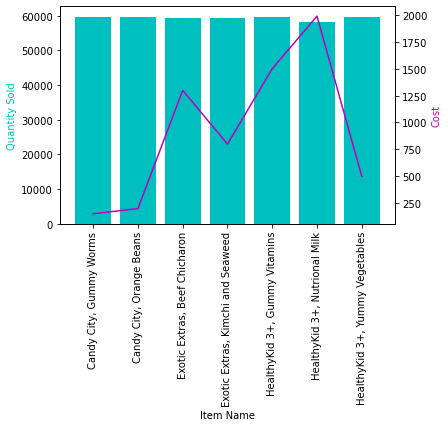

In [14]:
# Total Quantity Sold and Cost per Item Graph
# create a graph comparing the Total Quantity Sold and Cost per Item based on the values from total_sale_value
item_group = total_sale_value.groupby('Item Name')
quantity_sold = item_group.sum()['Total Quantity Sold per Item']
items = [item for item, df in item_group]

cost = total_sale_value.groupby('Item Name').mean()['Item Cost']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(items, quantity_sold, color = 'c')
ax2.plot(items, cost, 'm-')

ax1.set_xlabel('Item Name')
ax1.set_ylabel('Quantity Sold', color = 'c')
ax2.set_ylabel('Cost', color = 'm')
ax1.set_xticklabels(items, rotation = 'vertical', size = 10)

plt.show()

In [15]:
# Repeaters, Inactive and Engaged Metric
# extract transaction date, name and transaction month 
customer_activity = df_clean[['transaction_date','name','Transaction Month']]
# drop the other transactions of each customer in the same month and only consider the latest transaction per month
customer_activity = customer_activity.drop_duplicates(subset = ['name','Transaction Month'], keep = 'last').reset_index(drop = True)

# generate a truth table to indicate whether or not the customer purchased item/s in a certain month
transaction_truth_table = customer_activity.groupby(['name', 'Transaction Month'],sort=False).size().unstack(fill_value=0).astype(bool)
# create a summary of the truth values per customer using lists
transaction_truth_table_list = transaction_truth_table.values.tolist()
truth_value_summary = pd.DataFrame({'Truth Values Summary': transaction_truth_table_list})

# define functions to count the number of repeaters, inactive and engaged customers
def rep(x):
    customers_repeaters = []
    for j in range(6):
        if j == 0:
            customers_repeaters.append(0)
        elif x[j] == True and x[j-1] == True:
            customers_repeaters.append(1)
        elif x[j] == True and x[j-1] == False:
            customers_repeaters.append(0)
        elif x[j] == False or x[j-1] == False:
            customers_repeaters.append(0)
    return customers_repeaters

def ina(x):
    customers_inactive = []
    for j in range(6):
        if j == 0:
            customers_inactive.append(0)
        elif any(x[:j]) == True and x[j] == False:    
            customers_inactive.append(1)
        else:
            customers_inactive.append(0)
    return customers_inactive

def eng(x):
    customers_engaged = []
    for j in range(6):
        if all(x[:j+1])==True:
            customers_engaged.append(1)
        else:
            customers_engaged.append(0)
    return customers_engaged

# create additional columns to tally the repeaters, inactive and engaged for each month
truth_value_summary['Repeaters Tally'] = truth_value_summary.apply(lambda x:rep(x['Truth Values Summary']),axis=1)
truth_value_summary['Inactive Tally'] = truth_value_summary.apply(lambda x:ina(x['Truth Values Summary']),axis=1)
truth_value_summary['Engaged Tally'] = truth_value_summary.apply(lambda x:eng(x['Truth Values Summary']),axis=1)

# create new dataframes for each category of customers
repeaters_tally = pd.DataFrame(truth_value_summary['Repeaters Tally'].to_list(), columns=customer_activity['Transaction Month'].unique())
inactive_tally = pd.DataFrame(truth_value_summary['Inactive Tally'].to_list(), columns=customer_activity['Transaction Month'].unique())
engaged_tally = pd.DataFrame(truth_value_summary['Engaged Tally'].to_list(), columns=customer_activity['Transaction Month'].unique())

# compute for the sum for each category of customers in each month and created dataframes for the sums
repeaters_each_month = repeaters_tally.sum(axis=0)
inactive_each_month = inactive_tally.sum(axis=0)
engaged_each_month = engaged_tally.sum(axis=0)
repeaters = pd.DataFrame(repeaters_each_month).rename(columns={0: 'Repeaters'})
inactive = pd.DataFrame(inactive_each_month).rename(columns={0: 'Inactive'})
engaged = pd.DataFrame(engaged_each_month).rename(columns={0: 'Engaged'})

# merge the dataframes created and transpose the rows and columns 
activity_metric = pd.concat([repeaters, inactive, engaged],axis=1,join='inner').T
activity_metric

,January,February,March,April,May,June
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190
